In [242]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import lasso_path
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error


sns.set_theme(style="whitegrid")

# Load Data

In [243]:
X_train = pd.read_csv("../../data/preprocessed/X_train.csv", index_col=0)
y_train = pd.read_csv("../../data/preprocessed/y_train.csv", index_col=0)

# Get only numerical features
X_train["dataset"] = X_train["dataset"].astype("category")
X_train = pd.get_dummies(X_train)
X_train.head(5)

,model_DTC,model_KNC,model_LGBMC,model_LR,model_SVC,tuning_full,tuning_model,tuning_no,scoring_ACC,scoring_AUC,...,dataset_42738,dataset_42750,dataset_43098,dataset_43607,dataset_43890,dataset_43892,dataset_43896,dataset_43897,dataset_43900,dataset_43922
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [244]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

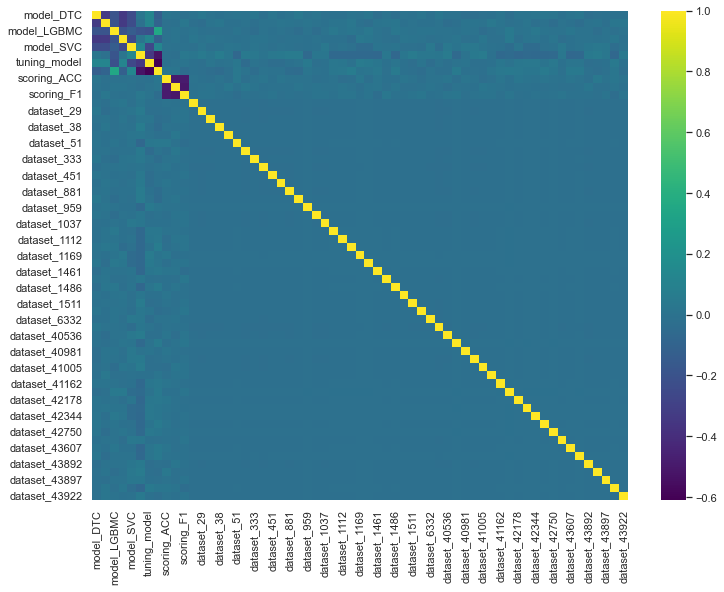

In [245]:
plt.figure(figsize=(12, 9))
sns.heatmap(X_train.corr(), cmap="viridis")
plt.show()

# LASSO

In [246]:
alphas_lasso, coefs_lasso, _ = lasso_path(X=X_train, y=y_train)

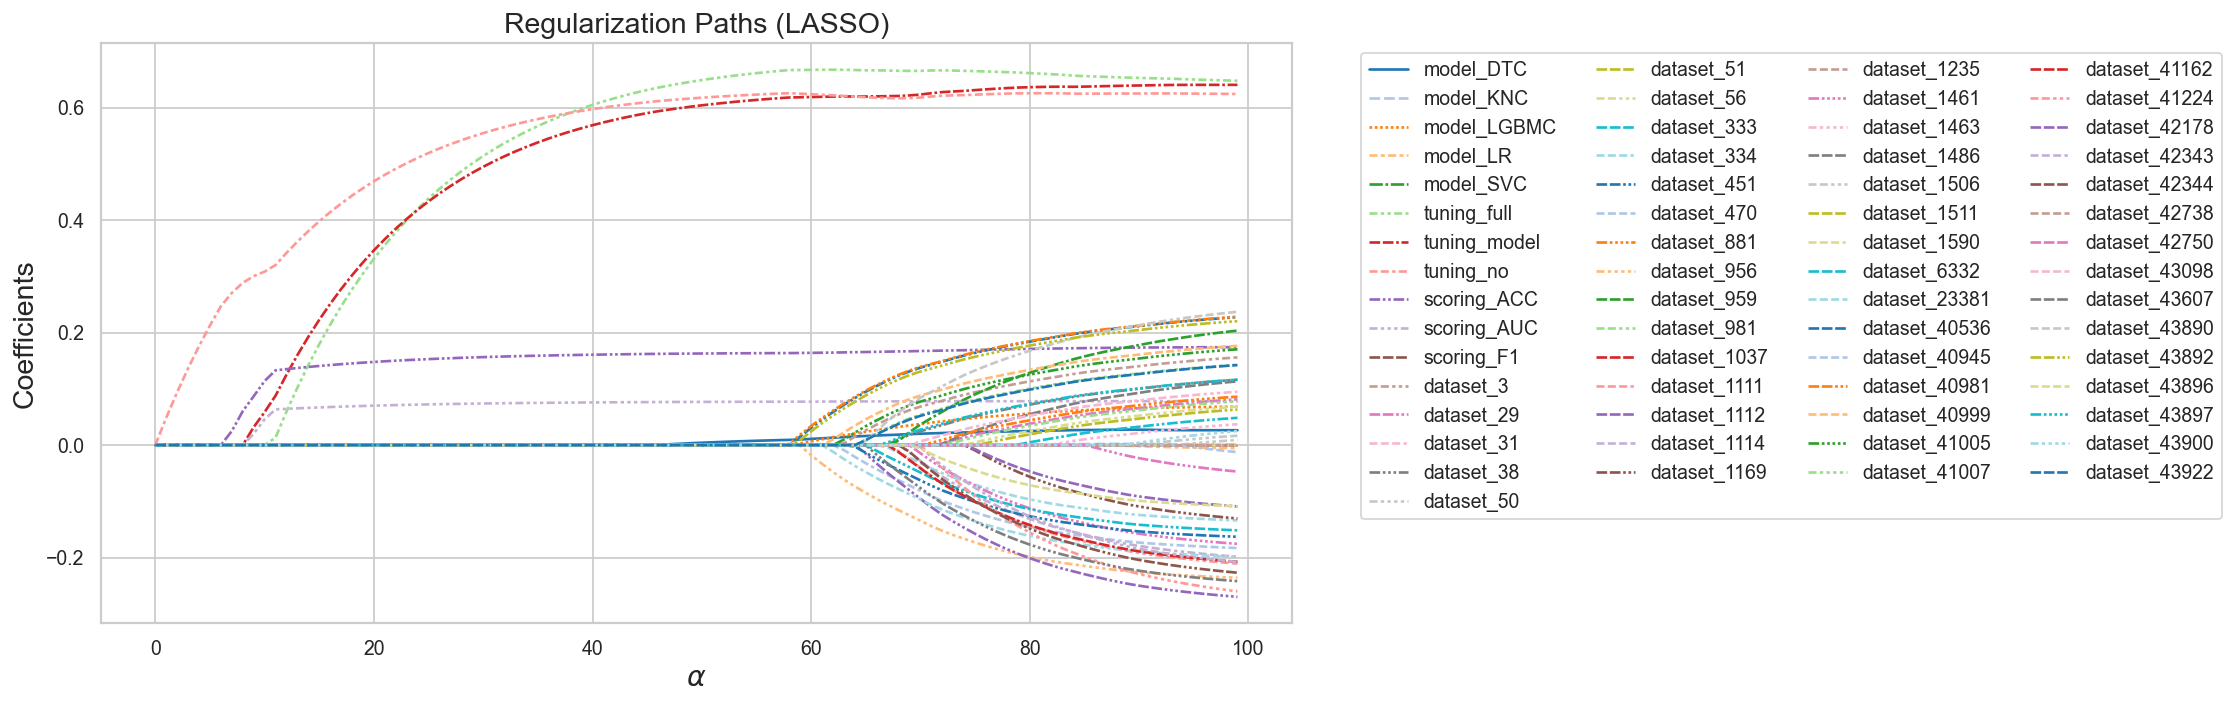

In [247]:
# Create DataFrame with coefficients and alpha from lasso
lasso_paths_df = pd.DataFrame(coefs_lasso[0,:,:], index=X_train.columns)
# Let the index be the features and the columns be the alphas for plotting reasons
#lasso_paths_df.columns = -np.log10(alphas_lasso)
# use log transformation for better visualization

plt.figure(figsize=(12, 6), dpi=128)
plt.title("Regularization Paths (LASSO)", size=16)
sns.lineplot(data=lasso_paths_df.T, palette="tab20")
plt.legend(bbox_to_anchor=(1.05, 1), ncol=4)
plt.xlabel("$\\alpha$", size=16)
plt.ylabel("Coefficients", size=16)
plt.show()

In [248]:
lassocv = LassoCV(n_jobs=-1, random_state=42).fit(X=X_train, y=y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [249]:
lassocv_res = pd.DataFrame({
    "feature": lassocv.feature_names_in_,
    "coefficient": lassocv.coef_
})
lassocv_res.head(5)

,feature,coefficient
0,model_DTC,0.026275
1,model_KNC,-0.000274
2,model_LGBMC,0.072248
3,model_LR,-0.008096
4,model_SVC,0.000000


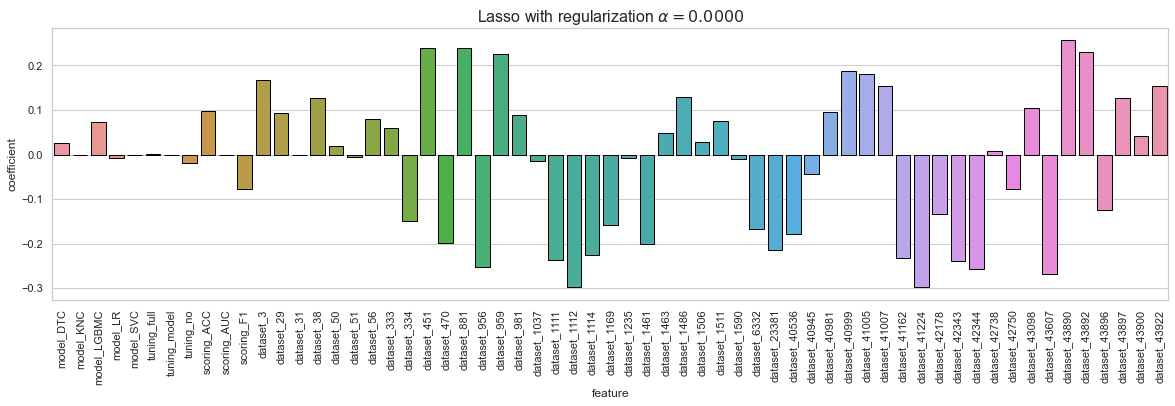

In [250]:
plt.figure(figsize=(20, 5))
plt.title(f"Lasso with regularization $\\alpha = {lassocv.alpha_:.4f}$", size=16)
sns.barplot(data=lassocv_res, x="feature", y="coefficient", edgecolor="black")
plt.xticks(rotation=90)
plt.show()

In [251]:
y_pred = lassocv.predict(X_test)
print("MSE = ", mean_squared_error(y_true=y_test, y_pred=y_pred))

MSE =  0.022880218557548054


## Findings
- Its actually quite interesting that the LassoCV outputs an alpha of 0, i.e. the ordinary OLS performs the best
- We should repeat the experiment as soon as we get the encoding for the encoder-feature right

# Testing Area: Linear Regression

In [252]:
import statsmodels.api as sm

In [253]:
mod = sm.OLS(exog=X_train, endog=y_train)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               cv_score   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     685.9
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:54:59   Log-Likelihood:                 13550.
No. Observations:               28843   AIC:                        -2.698e+04
Df Residuals:                   28785   BIC:                        -2.651e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
model_DTC         0.1720      0.002    101.622

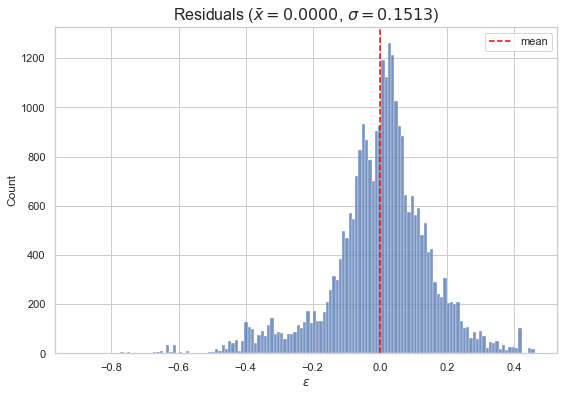

In [254]:
plt.figure(figsize=(9, 6))
plt.title(f"Residuals ($\\bar{{x}} = {np.mean(res.resid):.4f}$, $\\sigma = {np.std(res.resid):.4f}$)", size=16)
sns.histplot(res.resid)
plt.axvline(x=np.mean(res.resid), linestyle="--", color="red", label="mean")
plt.xlabel("$\\epsilon$")
plt.legend()
plt.show()

In [255]:
y_pred_ols = res.predict(X_test)
print("MSE", mean_squared_error(y_true=y_test, y_pred=y_pred_ols))

MSE 0.02287489818312226
